# ช่วงที่ 2 โมเดลตระกูลต้นไม้
สำหรับช่วงนี้เราจะเล่นกับโมเดลตระกูลต้นไม้ เช่น [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) และ [XGBoost (Gradient Boosting)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) 

เริ่มต้นด้วยการ mount Google Drive และ import library ที่ต้องใช้

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 30.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=d827ea501a8be1febfcae3b048cd19944fffb6f4deb2d6bfe82ccc52700fd183
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=c6bba611753809ace428b44120ec2e38f316f115da3da26eeff7780831c639db
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost, umap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import mode

# เตรียมข้อมูล
เป็นข้อมูลการทำนายกลุ่มลูกค้า (Customer segmentation) ที่เราได้เห็นมาแล้วเป็นตัวอย่างสุดท้ายของช่วงโมเดลตระกูลเส้นตรง

ดึงโค้ดเดิมสำหรับจัดการข้อมูลมาใช้
* เติมค่าที่หายไป
* แปลงตัวแปร Categorical ให้กลายเป็นตัวเลข

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/CustomerSegment.csv', index_col = 0)

data = data.drop('Work_Experience', axis = 1)
data = data.loc[~pd.isna(data['Profession']), :]

input_data = data.iloc[:, :-1]
output_data = data.iloc[:, -1]

categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

imputed_data = input_data.copy()
imputed_data[categorical_features] = imputed_data[categorical_features].fillna(imputed_data[categorical_features].mode().iloc[0])
imputed_data['Family_Size'] = imputed_data['Family_Size'].fillna(imputed_data['Family_Size'].mean()).astype(int) ## ปรับจำนวนสมาชิกในครอบครัวเป็นจำนวนเต็ม

formatted_data = imputed_data.copy()
formatted_data['Gender'] = (imputed_data['Gender'] == 'Male').astype(int)
formatted_data['Ever_Married'] = (imputed_data['Ever_Married'] == 'Yes').astype(int)
formatted_data['Graduated'] = (imputed_data['Graduated'] == 'Yes').astype(int)

dummies = pd.get_dummies(formatted_data['Var_1'], prefix = 'Var_1', prefix_sep = ':')
formatted_data = pd.concat([formatted_data.drop('Var_1', axis = 1), dummies], axis = 1)

dummies = pd.get_dummies(formatted_data['Profession'], prefix = 'Profession', prefix_sep = ':')
formatted_data = pd.concat([formatted_data.drop('Profession', axis = 1), dummies], axis = 1)

formatted_data['Spending_Score'] = formatted_data['Spending_Score'].map({'Low':0, 'Average':1, 'High':2})

pca_model = PCA(random_state = 25).fit(formatted_data)

ordered_class = sorted(pd.unique(output_data))
formatted_output = np.array([ordered_class.index(x) for x in output_data])

## การ save / load ตัวแปรใน Python
สมมติว่าเราเคยทำการแปลงข้อมูลและเทรน PCA ไว้แล้ว และอยากนำมาใช้ใหม่

In [ ]:
import pickle
pickle.dump([formatted_data, formatted_output, pca_model], open('customer_segment_processed.pkl', 'wb'))

ใน notebook ใหม่สามารถใช้ pickle.load ดึงตัวแปรเข้ามาได้เลย

,Gender,Ever_Married,Age,Graduated,Spending_Score,Family_Size,Var_1:Cat_1,Var_1:Cat_2,Var_1:Cat_3,Var_1:Cat_4,...,Var_1:Cat_7,Profession:Artist,Profession:Doctor,Profession:Engineer,Profession:Entertainment,Profession:Executive,Profession:Healthcare,Profession:Homemaker,Profession:Lawyer,Profession:Marketing
ID,,,,,,,,,,,,,,,,,,,,,
462809,1,0,22,0,0,4,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
462643,0,1,38,1,1,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


[3 0 1 1 0]


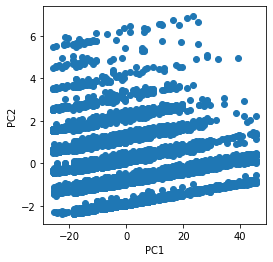

In [ ]:
customer_data, customer_label, customer_pca = pickle.load(open('customer_segment_processed.pkl', 'rb'))

display(customer_data.head(2))
print(customer_label[:5])

pca_embed = customer_pca.transform(customer_data)

plt.figure(figsize = (4, 4))
plt.scatter(pca_embed[:, 0], pca_embed[:, 1])
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

## แบ่งข้อมูลเป็นส่วน ๆ และทำการ standardize

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(formatted_data, formatted_output, test_size = 0.2,
                                                    stratify = output_data, random_state = 4649)

cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4649)

X_scaler = StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns) ## เพื่อความสะดวกในตอนวิเคราะห์ผลหลังทำโมเดล
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

## สร้างโมเดล Logistic Regression เอาไว้เปรียบเทียบ

In [ ]:
base_logistic = LogisticRegression(random_state = 4649, solver = 'liblinear') ## ตั้งค่าตัว optimizer เป็น liblinear ซึ่งรองรับ L1-regularization

logistic_params = {'C': [1e-4, 1e-3, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_logistic = GridSearchCV(estimator = base_logistic, param_grid = logistic_params, 
                             scoring = ['accuracy'], refit = 'accuracy', cv = cv_splitter)

grid_logistic.fit(X_train_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=LogisticRegression(random_state=4649,
                                          solver='liblinear'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             refit='accuracy', scoring=['accuracy'])

In [ ]:
grid_logistic_result = pd.DataFrame.from_dict(grid_logistic.cv_results_)
grid_logistic_result = grid_logistic_result.sort_values('rank_test_accuracy')
grid_logistic_result[['params', 'mean_test_accuracy', 'std_test_accuracy']].head(5)

,params,mean_test_accuracy,std_test_accuracy
8,"{'C': 1, 'penalty': 'l1'}",0.502124,0.009045
6,"{'C': 0.1, 'penalty': 'l1'}",0.501810,0.007337
10,"{'C': 10, 'penalty': 'l1'}",0.501652,0.009960
11,"{'C': 10, 'penalty': 'l2'}",0.501652,0.009960
9,"{'C': 1, 'penalty': 'l2'}",0.501338,0.009845


### ผลความแม่นยำที่ได้ อยู่ที่ราว ๆ 50% (คำตอบที่เป็นไปได้มีอยู่ 4 คลาส)

In [ ]:
grid_logistic_pred_test = grid_logistic.predict(X_test_std)
print(accuracy_score(y_test, grid_logistic_pred_test))

0.5040906230333543


## ลองสร้าง Random Forest ที่มีต้นไม้ 500 ต้น

In [ ]:
base_rf = RandomForestClassifier(n_estimators = 500, random_state = 4649)
base_rf.fit(X_train_std, y_train)

RandomForestClassifier(n_estimators=500, random_state=4649)

### ดูผลกระทบของจำนวนต้นไม้ที่เพิ่มขึ้น ต่อความแม่นยำของโมเดล
ทำโดยการดึงโมเดลต้นไม้ตัดสินใจ (Decision tree) ต้นที่ 1-N ภายใน Random Forest ออกมาใช้ทำนายผล

In [ ]:
sub_tree_counts = range(1, 500, 25)
sub_acc = pd.DataFrame(0, index = sub_tree_counts, columns = ['Accuracy'])

for n in sub_tree_counts:
    sub_rf = base_rf.estimators_[:n]
    sub_pred = np.mean([tree.predict_proba(X_test_std.to_numpy()) for tree in sub_rf], axis = 0)
    sub_pred = np.argmax(sub_pred, axis = 1)
    sub_acc.loc[n, 'Accuracy'] = accuracy_score(y_test, sub_pred)

sub_acc.head(10)

,Accuracy
1,0.426683
26,0.468219
51,0.470107
76,0.470107
101,0.472624
126,0.473883
151,0.477659
176,0.473254
201,0.471995
226,0.472624


## ปรับแต่ง (Tune) โมเดลต้นไม้ด้วย GridSearchCV
จากข้อมูลข้างต้น เลือกใช้จำนวนต้นไม้ที่ราว ๆ 100 ต้น น่าจะเพียงพอ

ตัวแปร hyperparameters หลักที่สำคัญคือ **max_features**, **max_depth**, และ **min_samples_split**

อย่าลืมตั้งค่า **n_jobs** เพื่อใช้หลาย CPU ช่วยทำให้เทรนเร็วขึ้น
* ต้นไม้ใน Random Forest สามารถเทรนคู่ขนานกันได้
* ตัวแปรแต่ละชุดที่ GridSearchCV ต้องลองก็สามารถทดสอบคู่ขนานกันได้

In [ ]:
base_rf = RandomForestClassifier(n_estimators = 100, random_state = 4649, n_jobs = 8)
rf_params = {'max_features': np.arange(0.1, 0.71, 0.2), ## ให้โมเดลได้เห็นแค่บางตัวแปรในเวลาหนึ่ง
             'max_depth': [5, 10, 20, None],            ## ความลึกของต้นไม้แต่ละต้น
             'min_samples_split': [2, 5, 11]}           ## จำนวนจุดข้อมูลสำหรับสนับสนุนการแตกกิ่ง

grid_rf = GridSearchCV(estimator = base_rf, param_grid = rf_params,
                       scoring = ['accuracy'], refit = 'accuracy', cv = cv_splitter)
grid_rf.fit(X_train_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=8, random_state=4649),
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': array([0.1, 0.3, 0.5, 0.7]),
                         'min_samples_split': [2, 5, 11]},
             refit='accuracy', scoring=['accuracy'])

### ผลหลังจาก tune แล้ว

In [ ]:
grid_rf_result = pd.DataFrame.from_dict(grid_rf.cv_results_)
grid_rf_result = grid_rf_result.sort_values('rank_test_accuracy')
grid_rf_result[['params', 'mean_test_accuracy', 'std_test_accuracy']].head(5)

,params,mean_test_accuracy,std_test_accuracy
17,"{'max_depth': 10, 'max_features': 0.3000000000...",0.534225,0.013212
16,"{'max_depth': 10, 'max_features': 0.3000000000...",0.533124,0.011441
15,"{'max_depth': 10, 'max_features': 0.3000000000...",0.530921,0.011460
14,"{'max_depth': 10, 'max_features': 0.1, 'min_sa...",0.529976,0.010059
20,"{'max_depth': 10, 'max_features': 0.5000000000...",0.529976,0.014115


In [ ]:
grid_rf_pred_test = grid_rf.predict(X_test_std)
print(accuracy_score(y_test, grid_rf_pred_test))

0.5368156073001888


## ลองใช้ XGBoost (Gradient Boosting)
accuracy ที่ได้ในปัจจุบันค่อนข้างต่ำ อาจจะเป็นเพราะโมเดลไม่สามารถเรียนรู้ pattern ได้ทั้งหมด โมเดลตระกูล Boosting อาจจะช่วยได้

ยังไม่กำกับเรื่องการเลิกเทรนก่อนกำหนด (Early stopping)

ตัวแปร hyperparameters หลักที่สำคัญคือ **min_child_weight**, **max_depth**, และ **gamma**

In [ ]:
base_xgb = xgboost.XGBClassifier(n_estimators = 100, use_label_encoder = False, tree_method = 'hist')

xgb_params = {'min_child_weight': np.arange(0.5, 5, 0.5),  ## คล้ายกับจำนวนจุดข้อมูลสำหรับสนับสนุนการแตกกิ่ง
              'max_depth': [2, 5, 10, 20],                 ## ความลึกของต้นไม้แต่ละต้น
              'gamma': [0, 2, 5, 10]}                      ## คล้ายกับความเปลี่ยนแปลงใน Purity ที่ต้องการในการแตกกิ่ง 

grid_xgb = GridSearchCV(estimator = base_xgb, param_grid = xgb_params,
                        scoring = ['accuracy'], refit = 'accuracy', cv = cv_splitter, n_jobs = 8)
grid_xgb.fit(X_train_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=XGBClassifier(tree_method='hist',
                                     use_label_encoder=False),
             n_jobs=8,
             param_grid={'gamma': [0, 2, 5, 10], 'max_depth': [2, 5, 10, 20],
                         'min_child_weight': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])},
             refit='accuracy', scoring=['accuracy'])

### ผลจากการ tune รอบที่ 1 (เฉพาะตัวแปร Hyperparameters ที่เกี่ยวข้องกับความซับซ้อนของโมเดล)

In [ ]:
grid_xgb_result = pd.DataFrame.from_dict(grid_xgb.cv_results_)
grid_xgb_result = grid_xgb_result.sort_values('rank_test_accuracy')
grid_xgb_result[['params', 'mean_test_accuracy', 'std_test_accuracy']].head(5)

,params,mean_test_accuracy,std_test_accuracy
48,"{'gamma': 2, 'max_depth': 5, 'min_child_weight...",0.536900,0.010169
45,"{'gamma': 2, 'max_depth': 5, 'min_child_weight...",0.536743,0.011853
52,"{'gamma': 2, 'max_depth': 5, 'min_child_weight...",0.536585,0.009687
50,"{'gamma': 2, 'max_depth': 5, 'min_child_weight...",0.535327,0.009553
49,"{'gamma': 2, 'max_depth': 5, 'min_child_weight...",0.535327,0.008033


In [ ]:
grid_xgb_pred_test = grid_xgb.predict(X_test_std)
print(accuracy_score(y_test, grid_xgb_pred_test))

0.5305223410950283


### ปรับแต่งเพิ่มเติมโดยใส่ตัวแปร Hyperparameters ที่เกี่ยวข้องกับ Bagging ด้วย
คงค่าตัวแปร Hyperparameters บางตัวจากรอบแรกเพื่อลดเวลาในการเทรน

พบว่า **min_child_weight** ไม่ค่อยมีผลสำหรับงานนี้

In [26]:
for i in range(5):
    print(grid_xgb_result[['params']].iloc[i].values) ## พิมพ์ค่าตัวแปร Hyperparameters ที่ดีมาสังเกตเพื่อเลือกค่าสำหรับตั้ง

[{'gamma': 2, 'max_depth': 5, 'min_child_weight': 2.0}]
[{'gamma': 2, 'max_depth': 5, 'min_child_weight': 0.5}]
[{'gamma': 2, 'max_depth': 5, 'min_child_weight': 4.0}]
[{'gamma': 2, 'max_depth': 5, 'min_child_weight': 3.0}]
[{'gamma': 2, 'max_depth': 5, 'min_child_weight': 2.5}]


In [27]:
tuned_xgb = xgboost.XGBClassifier(n_estimators = 100, use_label_encoder = False, tree_method = 'hist',
                                  max_depth = 5, gamma = 2, min_child_weight = 2)

xgb_params = {'subsample': np.arange(0.6, 1.01, 0.1),        ## สุ่มจุดข้อมูลบางจุดมาเทรน
              'colsample_bynode': np.arange(0.3, 0.71, 0.1)} ## ให้โมเดลได้เห็นแค่บางตัวแปรในเวลาหนึ่ง 

grid_xgb_v2 = GridSearchCV(estimator = tuned_xgb, param_grid = xgb_params,
                           scoring = ['accuracy'], refit = 'accuracy', cv = cv_splitter, n_jobs = 8)
grid_xgb_v2.fit(X_train_std, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=XGBClassifier(gamma=2, max_depth=5, min_child_weight=2,
                                     tree_method='hist',
                                     use_label_encoder=False),
             n_jobs=8,
             param_grid={'colsample_bynode': array([0.3, 0.4, 0.5, 0.6, 0.7]),
                         'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
             refit='accuracy', scoring=['accuracy'])

### ผลหลังจากการ tune รอบที่ 2 (เพิ่ม Bagging)

In [28]:
grid_xgb_result_v2 = pd.DataFrame.from_dict(grid_xgb_v2.cv_results_)
grid_xgb_result_v2 = grid_xgb_result_v2.sort_values('rank_test_accuracy')
grid_xgb_result_v2[['params', 'mean_test_accuracy', 'std_test_accuracy']].head(5)

,params,mean_test_accuracy,std_test_accuracy
12,"{'colsample_bynode': 0.5, 'subsample': 0.79999...",0.540677,0.008045
23,"{'colsample_bynode': 0.7000000000000002, 'subs...",0.540677,0.009140
3,"{'colsample_bynode': 0.3, 'subsample': 0.89999...",0.540362,0.009882
16,"{'colsample_bynode': 0.6000000000000001, 'subs...",0.540362,0.008667
1,"{'colsample_bynode': 0.3, 'subsample': 0.7}",0.540362,0.009769


### ผลการทำงานบน test set

In [29]:
tuned_xgb_v2_pred_test = grid_xgb_v2.predict(X_test_std)
print(accuracy_score(y_test, tuned_xgb_v2_pred_test))

0.5399622404027691


In [30]:
for i in range(5):
    print(grid_xgb_result_v2[['params']].iloc[i].values) ## พิมพ์ค่าตัวแปร Hyperparameters ที่ดีมาสังเกตเพื่อเลือกค่าสำหรับตั้ง

[{'colsample_bynode': 0.5, 'subsample': 0.7999999999999999}]
[{'colsample_bynode': 0.7000000000000002, 'subsample': 0.8999999999999999}]
[{'colsample_bynode': 0.3, 'subsample': 0.8999999999999999}]
[{'colsample_bynode': 0.6000000000000001, 'subsample': 0.7}]
[{'colsample_bynode': 0.3, 'subsample': 0.7}]


## ดูกราฟการเรียนรู้ของ XGBoost
แบ่ง training set ออกมาเป็น training และ validation แยก เพื่อนำ validation มาใช้วัดผลการเรียนรู้และเพื่อหยุดการเทรนก่อนเวลา

In [31]:
local_X_train, local_X_val, local_y_train, local_y_val = train_test_split(X_train_std, y_train, test_size = 0.2,
                                                                          stratify = y_train, random_state = 4649)

มาตร (metric) สำหรับวัดผล ควรจะเลือกให้ตรงกับชนิดของโจทย์ โดยดูได้ [ที่นี่](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)

ในที่นี้เราใช้ **mlogloss** หรือ negative log likelihoos ร่วมกับ **merror** หรือ multi-class error

**ระวัง** ถ้าใส่ metric หลายตัว โมเดลจะใช้ metric ตัวสุดท้ายในการเลิกเทรน

ใส่ทั้ง training และ validation sets ใน **eval_set** เพื่อบอกให้โมเดลเก็บค่า loss ของทั้งสองส่วน

In [42]:
tuned_xgb_v2 = xgboost.XGBClassifier(n_estimators = 200, use_label_encoder = False, 
                                     tree_method = 'hist', max_depth = 5, gamma = 2, 
                                     min_child_weight = 2, colsample_bytree = 0.5, subsample = 0.8)

tuned_xgb_v2.fit(local_X_train, local_y_train, 
                 eval_set = [(local_X_train, local_y_train), (local_X_val, local_y_val)],
                 eval_metric = ['merror', 'mlogloss'], early_stopping_rounds = 5, verbose = 0)

XGBClassifier(colsample_bytree=0.5, gamma=2, max_depth=5, min_child_weight=2,
              n_estimators=200, objective='multi:softprob', subsample=0.8,
              tree_method='hist', use_label_encoder=False)

In [33]:
def view_learning_graph(xgb_model, graph_title):
    train_loss = xgb_model.evals_result_['validation_0']['mlogloss']
    val_loss = xgb_model.evals_result_['validation_1']['mlogloss']
    stopped_n_tree = xgb_model.best_iteration
    num_step = len(train_loss)

    train_acc = [1 - x for x in xgb_model.evals_result_['validation_0']['merror']]
    val_acc = [1 - x for x in xgb_model.evals_result_['validation_1']['merror']]

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_step), train_loss, label = 'Training')
    plt.plot(range(num_step), val_loss, label = 'Validation')
    plt.legend()
    plt.plot([stopped_n_tree, stopped_n_tree], [np.min(train_loss), np.max(val_loss)], '--k')
    plt.xlabel('Number of trees'); plt.ylabel('Multiclass log-loss')
    plt.title(graph_title + ', Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(num_step), train_acc, label = 'Training')
    plt.plot(range(num_step), val_acc, label = 'Validation')
    plt.legend()
    plt.plot([stopped_n_tree, stopped_n_tree], [np.min(val_acc), np.max(train_acc)], '--k')
    plt.xlabel('Number of trees'); plt.ylabel('Accuracy')
    plt.title(graph_title + ', Accuracy')

    plt.tight_layout()
    plt.show()

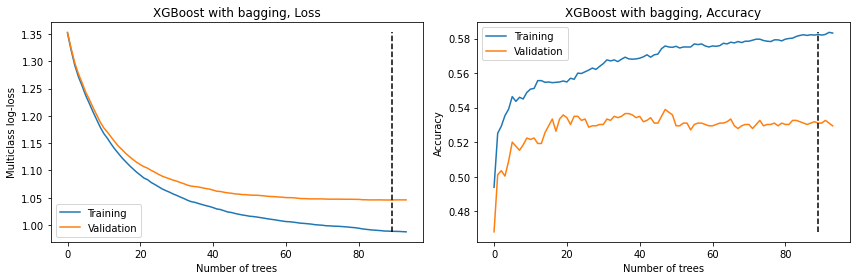

In [34]:
view_learning_graph(tuned_xgb_v2, graph_title = 'XGBoost with bagging')

## ผลกระทบของอัตราการเรียนรู้ (Learning rate)

In [43]:
tuned_xgb_default_pred_test = tuned_xgb_v2.predict(X_test_std)
print('Default learning rate:', tuned_xgb_v2.learning_rate)

Default learning rate: 0.1


### Learning rate = 0.02
อย่าลืมเพิ่มจำนวน step ที่ **n_estimators** เพื่อให้สอดคล้องกับอัตราการเรียนรู้ที่ต่ำลงด้วย

In [44]:
tuned_xgb_v2.learning_rate = 0.02
tuned_xgb_v2.n_estimators = 2000

tuned_xgb_v2.fit(local_X_train, local_y_train, eval_set = [(local_X_train, local_y_train), (local_X_val, local_y_val)],
                 eval_metric = ['merror', 'mlogloss'], early_stopping_rounds = 5, verbose = 0)

tuned_xgb_slow_pred_test = tuned_xgb_v2.predict(X_test_std)

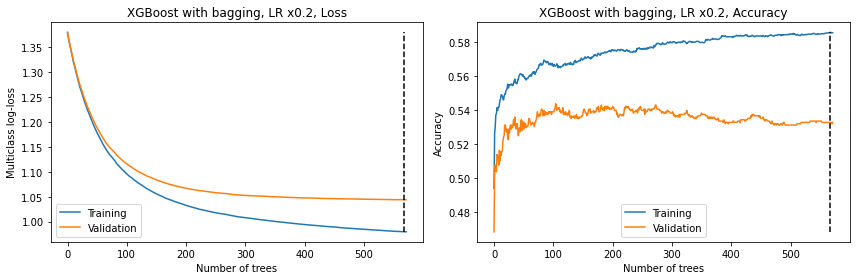

In [40]:
view_learning_graph(tuned_xgb_v2, graph_title = 'XGBoost with bagging, LR x0.2')

### Learning rate = 0.5

In [45]:
tuned_xgb_v2.learning_rate = 0.5
tuned_xgb_v2.n_estimators = 100

tuned_xgb_v2.fit(local_X_train, local_y_train, eval_set = [(local_X_train, local_y_train), (local_X_val, local_y_val)],
                 eval_metric = ['merror', 'mlogloss'], early_stopping_rounds = 5, verbose = 0)

tuned_xgb_fast_pred_test = tuned_xgb_v2.predict(X_test_std)

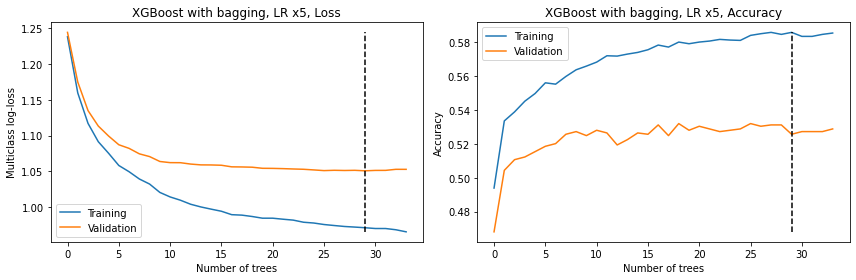

In [46]:
view_learning_graph(tuned_xgb_v2, graph_title = 'XGBoost with bagging, LR x5')

### เปรียบเทียบผลการปรับ Learning rate

In [41]:
def get_best_acc(xgb_model):
    val_acc = xgb_model.evals_result_['validation_1']['merror']
    stopped_n_tree = xgb_model.best_iteration

    return 1 - val_acc[stopped_n_tree]

In [47]:
print('Default LR = 0.1:', accuracy_score(y_test, tuned_xgb_v2_pred_test))
print('   Fast LR = 0.5:', accuracy_score(y_test, tuned_xgb_fast_pred_test))
print('  Slow LR = 0.02:', accuracy_score(y_test, tuned_xgb_slow_pred_test))

Default LR = 0.1: 0.5399622404027691
   Fast LR = 0.5: 0.5298930144745123
  Slow LR = 0.02: 0.539332913782253


## เปรียบเทียบ Confusion matrix ระหว่าง Logistic Regression, Random Forest, และ XGBoost

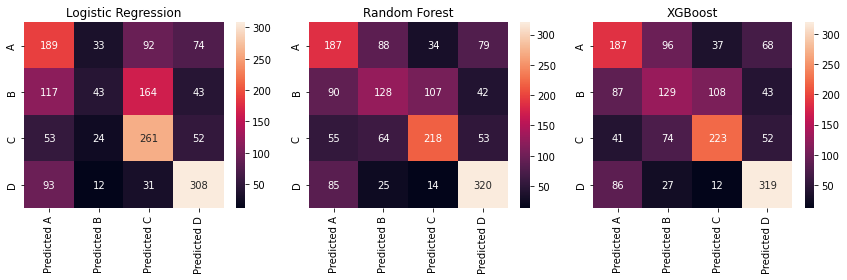

In [50]:
conf_mat_logistic = pd.DataFrame(confusion_matrix(y_test, grid_logistic_pred_test),
                                 index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
conf_mat_rf = pd.DataFrame(confusion_matrix(y_test, grid_rf_pred_test),
                           index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])
conf_mat_xgb = pd.DataFrame(confusion_matrix(y_test, tuned_xgb_default_pred_test),
                            index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])

plt.figure(figsize = (12, 4))

for i, [conf_mat, name] in enumerate(zip([conf_mat_logistic, conf_mat_rf, conf_mat_xgb], 
                                       ['Logistic Regression', 'Random Forest', 'XGBoost']), start = 1):
    plt.subplot(1, 3, i)
    sns.heatmap(conf_mat, annot = True, fmt = 'd')
    plt.title(name)

plt.tight_layout()
plt.show()

## การถ่วงน้ำหนักจุดข้อมูลด้วย sample_weights

In [61]:
local_sample_weight = np.ones([len(local_y_train), ])
local_sample_weight[local_y_train == 0] = 1.05
local_sample_weight[local_y_train == 1] = 1.05

tuned_xgb_v2.learning_rate = 0.1
tuned_xgb_v2.n_estimators = 200

tuned_xgb_v2.fit(local_X_train, local_y_train, sample_weight = local_sample_weight, 
                 eval_set = [(local_X_train, local_y_train), (local_X_val, local_y_val)],
                 eval_metric = ['merror', 'mlogloss'], early_stopping_rounds = 5, verbose = 0)

tuned_xgb_weighted_pred_test = tuned_xgb_v2.predict(X_test_std)

print('Unweighted:', accuracy_score(y_test, tuned_xgb_v2_pred_test))
print('Weighted B:', accuracy_score(y_test, tuned_xgb_weighted_pred_test))

Unweighted: 0.5399622404027691
Weighted B: 0.5424795468848332


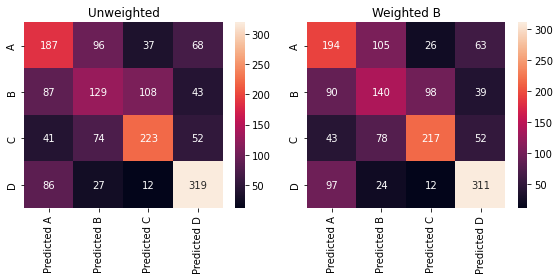

In [62]:
conf_mat_xgb_weighted = pd.DataFrame(confusion_matrix(y_test, tuned_xgb_weighted_pred_test),
                                     index = ordered_class, columns = ['Predicted ' + x for x in ordered_class])

plt.figure(figsize = (8, 4))

plt.subplot(1, 2, 1);
sns.heatmap(conf_mat_xgb, annot = True, fmt = 'd'); plt.title('Unweighted')

plt.subplot(1, 2, 2);
sns.heatmap(conf_mat_xgb_weighted, annot = True, fmt = 'd'); plt.title('Weighted B')

plt.tight_layout()
plt.show()

# ดูการกระจายตัวของข้อมูลด้วย UMAP เพื่อตรวจสอบความผิดพลาดของโมเดล

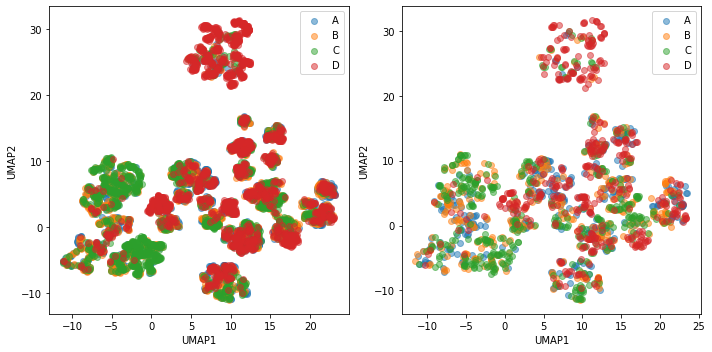

In [73]:
umap_model = umap.UMAP(n_neighbors = 200, min_dist = 1, random_state = 4649).fit(X_train_std)
umap_train_embed = umap_model.transform(X_train_std)
umap_test_embed = umap_model.transform(X_test_std)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)

for cls_i, cls in enumerate(ordered_class):
    plt.scatter(umap_train_embed[y_train == cls_i, 0], umap_train_embed[y_train == cls_i, 1], 
                alpha = 0.5, label = str(cls))

plt.legend(); plt.xlabel('UMAP1'); plt.ylabel('UMAP2')

plt.subplot(1, 2, 2)

for cls_i, cls in enumerate(ordered_class):
    plt.scatter(umap_test_embed[y_test == cls_i, 0], umap_test_embed[y_test == cls_i, 1], 
                alpha = 0.5, label = str(cls))

plt.legend(); plt.xlabel('UMAP1'); plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()

เปรียบเทียบคำตอบของโมเดลกับผลเฉลย

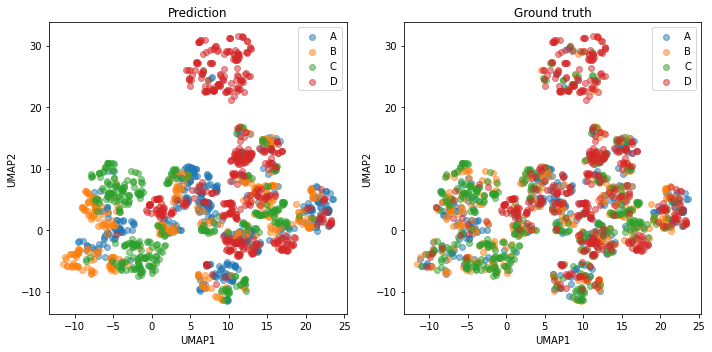

In [75]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)

for cls_i, cls in enumerate(ordered_class):
    plt.scatter(umap_test_embed[tuned_xgb_weighted_pred_test == cls_i, 0], 
                umap_test_embed[tuned_xgb_weighted_pred_test == cls_i, 1], 
                alpha = 0.5, label = str(cls))

plt.legend(); plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.title('Prediction')

plt.subplot(1, 2, 2)

for cls_i, cls in enumerate(ordered_class):
    plt.scatter(umap_test_embed[y_test == cls_i, 0], umap_test_embed[y_test == cls_i, 1], 
                alpha = 0.5, label = str(cls))

plt.legend(); plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.title('Ground truth')

plt.tight_layout()
plt.show()